# Advanced Lane Line Detection
#### Self Driving Car Nanodegree Course - Project 4 - Alistair S Kirk

#### Camera Calibration:

In [ ]:
# Define a function for importing camera calibration images and returning camera calibration files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

#Get images
fimages = glob.glob('camera_cal/calibration*.jpg')

objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#Init objpoints
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinates

# Make a list of calibration images
for fname in fimages:
    print(fname)
    
    #convert to image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
calib_pickle = {"objpoints": objpoints, "imgpoints": imgpoints}
pickle.dump( calib_pickle, open( "my_calib_pickle.p", "wb" ) )  

print("Done with imgpoints size: {} and objpoints size: {}".format(len(imgpoints), len(objpoints)))


In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "my_calib_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('camera_cal/calibration2.jpg')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

undistorted,mtx,dst = cal_undistort(img, objpoints, imgpoints)

#Save calibrated camera matrix and dst
cam_params = {"mtx": mtx, "dst": dst}
pickle.dump( cam_params, open( "calib_cam_params.p", "wb" ) )  

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define and Test Perpective Transform

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open( "my_calib_pickle.p", "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

# Read in an image
img = cv2.imread('camera_cal/calibration3.jpg')

# Define a function that takes an image, number of x and y points, camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:        
        # Choose offset from image corners to plot detected corners
        # Arbitrarily select 100 pixels
        offset = 100 # offset for dst points
        # Get image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points get the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, arbitrarily choosing points
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

_, mtx, dist = cal_undistort(img, objpoints, imgpoints)
nx,ny = 9,6 # Redefine calib squares for testing 

undistorted,_ = corners_unwarp(img, nx, ny, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Perspective Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define Road Surface Perspective Warp Function

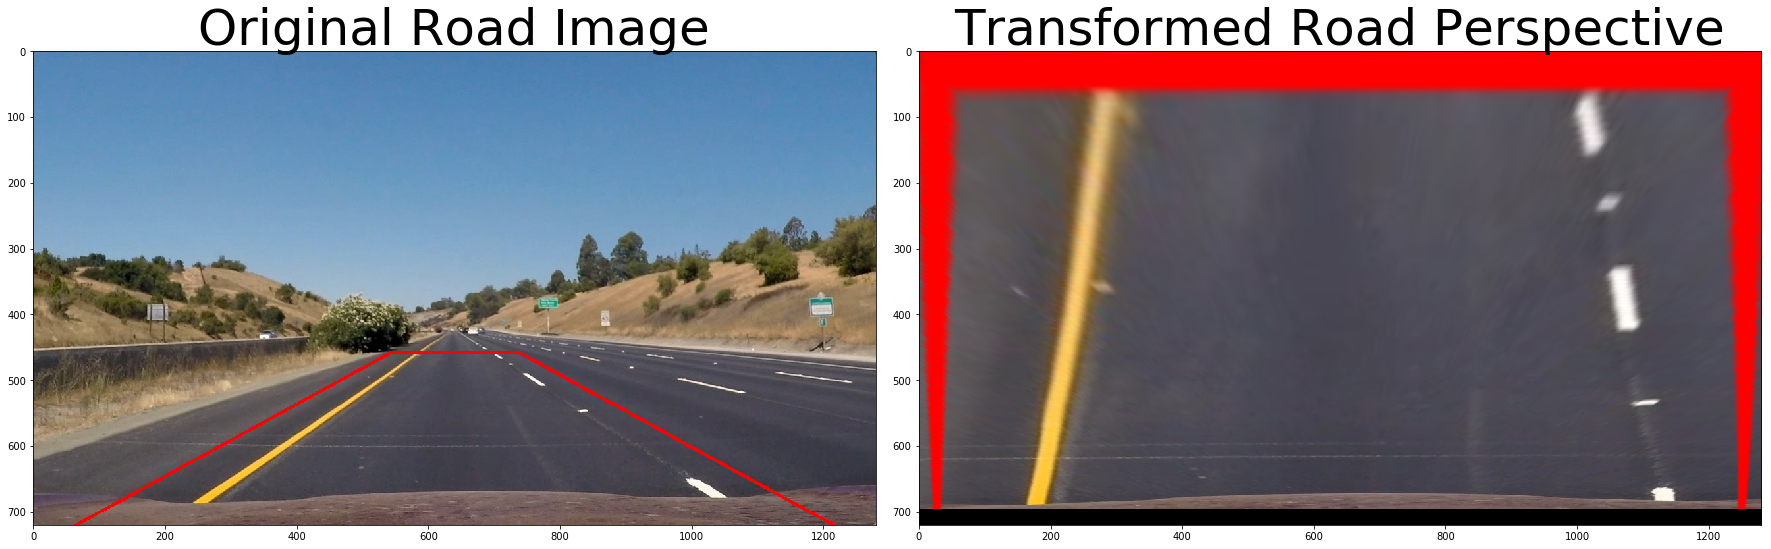

In [4]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# Read in the saved camera calibration data
calib_pickle = pickle.load( open( "calib_cam_params.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dst"]

# Read in an image
img = cv2.imread('test_images/straight_lines1.jpg')
img = img[:,:,::-1] #Correcting BGR to RGB

# Define a function that takes an image, arbitrary trap mask, camera matrix and distortion coefficients
def road_unwarp(img, corners, mtx, dist, offset=25):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    #gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # Get image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points get the outer four detected corners
    src = np.float32([corners[1], corners[2], corners[3], corners[0]])
    # For destination points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

def roadmask(img, ApexResolution = 0.15, HorizonVert = 0.635, Nearlimit = 0.05):
    # Generate Road Mask
    # ApexResolution = 0.15 #Set percentage/100 of image for apex spread
    # HorizonVert = 0.635 #Set farfield distance (% of vertical from y=0)
    # Nearlimit = 0.05 #Set nearfield distance (% of horizontal from x=0)
    imshape = img.shape
    #Define mask vertices by using generalized limits defined above ([BL,TL,TR,BR])
    verts = np.float32([(imshape[1]*Nearlimit,imshape[0]),((1-ApexResolution)*imshape[1]*0.5, imshape[0]*HorizonVert), ((1+ApexResolution)*imshape[1]*0.5, imshape[0]*HorizonVert), (imshape[1]*(1-Nearlimit),imshape[0])])
    return verts

# Get Warped Road Plane using camera calibration data
verts = roadmask(img)

#Draw masking lines
l_color=[0, 0, 255]
thickness=3
cv2.line(img[:,:,::-1], (int(verts[0,0]), int(verts[0,1])), (int(verts[1,0]), int(verts[1,1])), l_color, thickness)
cv2.line(img[:,:,::-1], (int(verts[2,0]), int(verts[2,1])), (int(verts[3,0]), int(verts[3,1])), l_color, thickness)
cv2.line(img[:,:,::-1], (int(verts[1,0]), int(verts[1,1])), (int(verts[2,0]), int(verts[2,1])), l_color, thickness)

undistorted,_ = road_unwarp(img, verts, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Road Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Transformed Road Perspective', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Define Gradient Detection and Combination Functions

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
# Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.arctan2(abs_sobely, abs_sobelx)
    #print(scaled_sobel[50])
    #mag = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    # Rescale back to 8 bit integer
    #scaled_sobel = np.uint8(255*mag/np.max(mag))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return binary_output

def combined_sobel(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(10, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

#### Create a pipeline function to generate combined image using gradients and colour spaces 

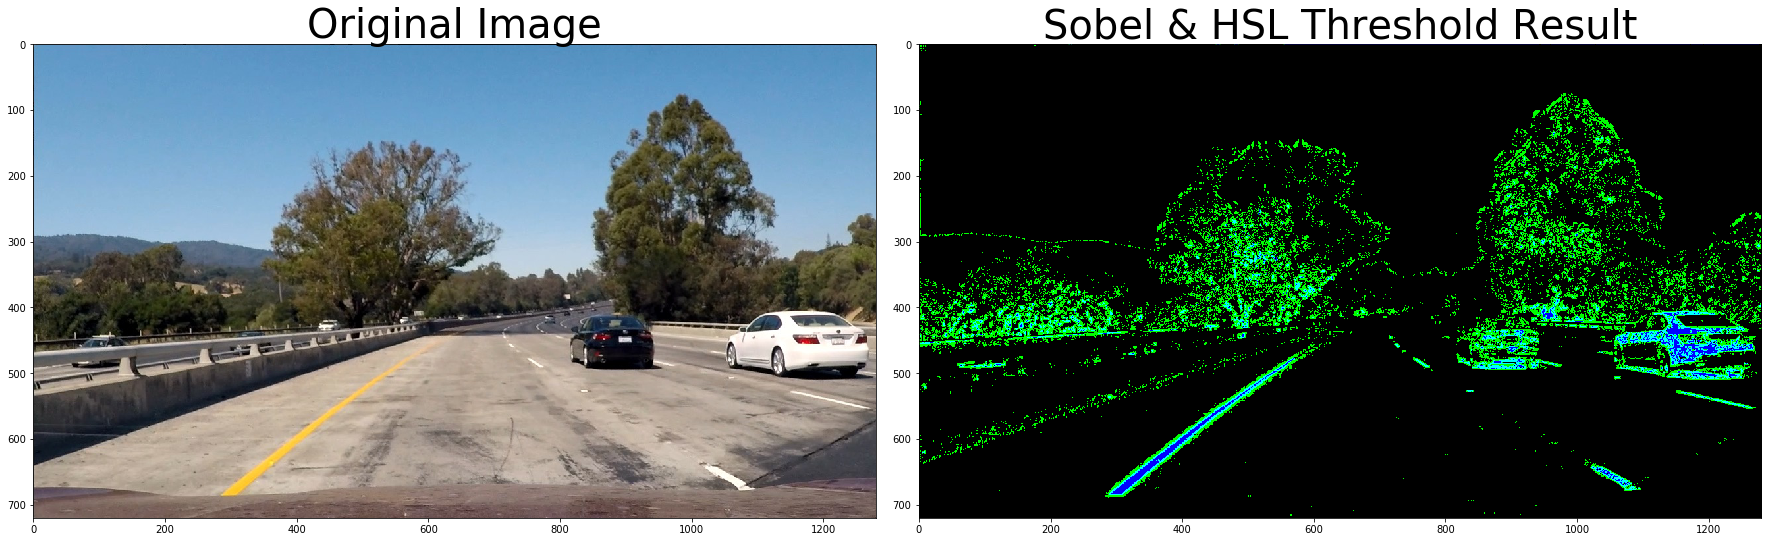

In [69]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test1.jpg')

def colour_grad_thresh(img, s_thresh=(170, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    #sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    #scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    #sxbinary = np.zeros_like(scaled_sobel)
    #sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    #Threshold x,y,mag Gradient by using the S Channel. Can try using l_channel and gray, but s seems best.
    sxbinary = combined_sobel(s_channel)
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #color_binary[:,:,0] = 1
    return color_binary
    
result = colour_grad_thresh(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Sobel & HSL Threshold Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Create Warped Binary Image

(720, 1280)


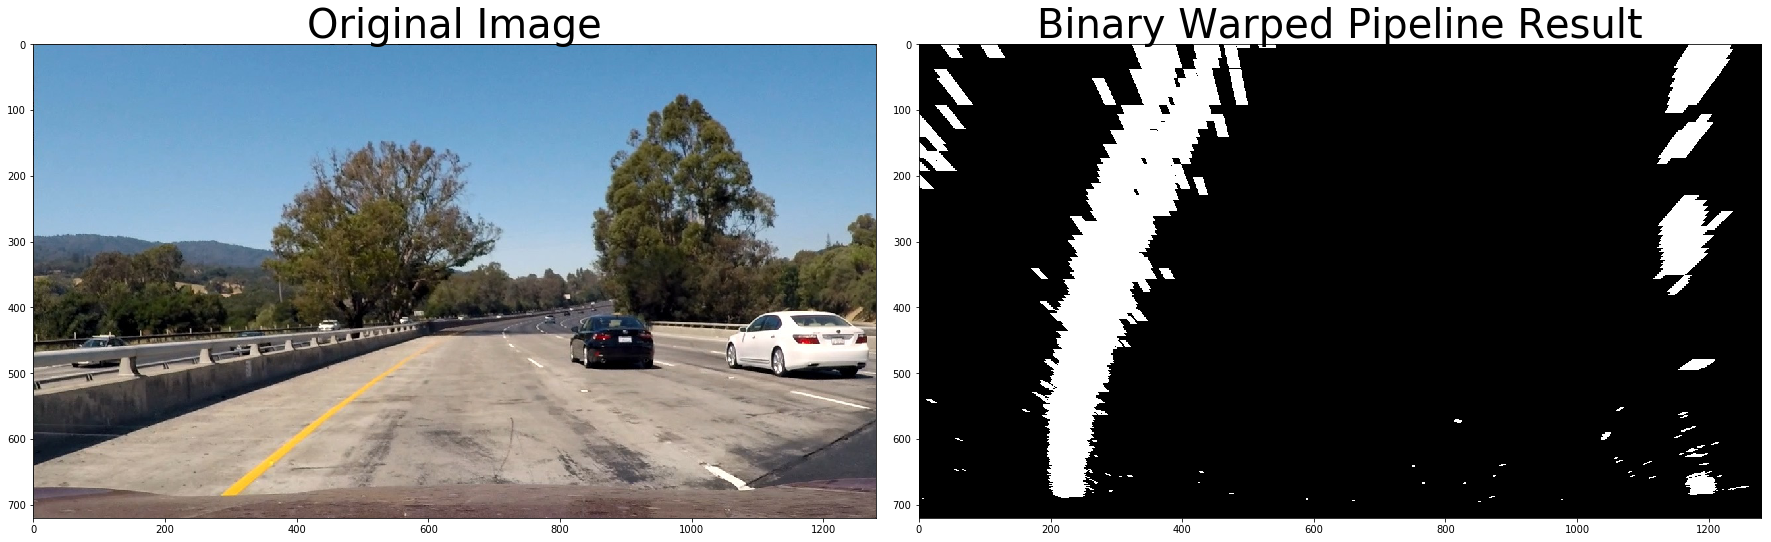

In [70]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

# Read in the saved camera calibration data
calib_pickle = pickle.load( open( "calib_cam_params.p", "rb" ) )
mtx = calib_pickle["mtx"]
dist = calib_pickle["dst"]

# Read in an image
image = mpimg.imread('test_images/test1.jpg')

def binary_warp(image):
    verts = roadmask(image)

    warped = colour_grad_thresh(image, s_thresh=(170, 255))

    warped,_ = road_unwarp(warped, verts, mtx, dist)

    binary_warped = np.zeros_like(warped[:,:,0])
    binary_warped[(warped[:,:,1] > 0) & (warped[:,:,1] <= 255)] = 1
    binary_warped[(warped[:,:,2] > 0) & (warped[:,:,2] <= 255)] = 1
    return binary_warped

binary_warped = binary_warp(image)

print(binary_warped.shape)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Warped Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Finding Lane Lines

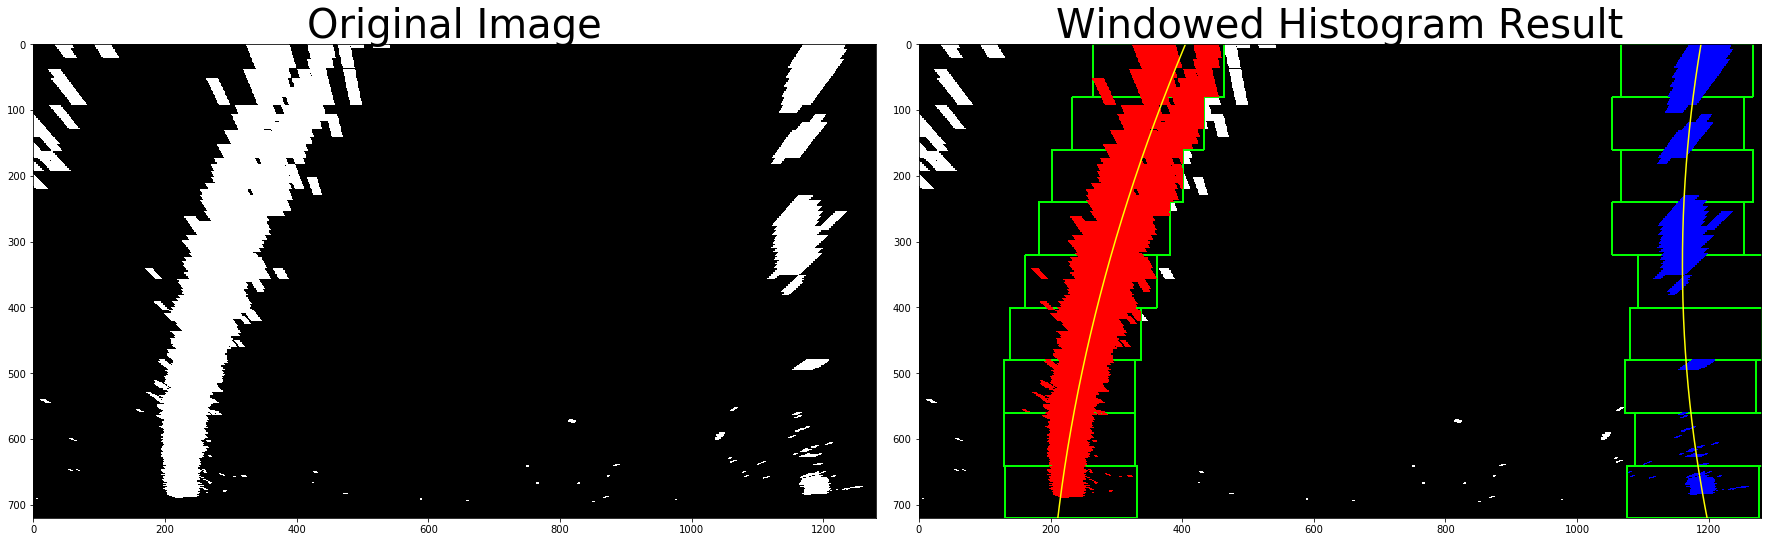

In [78]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def window_lanefind(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    halfmark = int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[halfmark:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack([binary_warped, binary_warped, binary_warped])*255
    out_img = np.uint8(out_img)
    #print(out_img.dtype)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Visualization:
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fitx,right_fitx,ploty,out_img

left_fitx,right_fitx,ploty,out_img = window_lanefind(binary_warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Windowed Histogram Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Assume you already have a function from a previous analysis

In [79]:
def cont_linesearch(binary_warped, plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if (plot==True):
        # Visualize:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = np.uint8(out_img)
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fitx,right_fitx,ploty

left_fitx,right_fitx,ploty = cont_linesearch(binary_warped, plot=True)


UnboundLocalError: local variable 'left_fit' referenced before assignment

#### Define Radius of Curvature Calculation Function

In [ ]:
# Pass in left and right curve data from np.polyfit
# Optional pass in meters per pixel in x & y dimensions ym/xm _per_pix, also image pixels y_pix
def radcurve(left_fit, right_fit, ypix = 720, ym_per_pix = 30/720, xm_per_pix = 3.7/700 )    
    # Define y-value where we want radius of curvature:
    # Choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, ypix-1, num=ypix)# to cover same y-range as image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
return left_curverad, right_curverad
